# Import liberies

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functions import *
from pipeline import *

from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve


from xgboost import XGBClassifier


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

# The Data

In [2]:
heartdf=pd.read_csv('heart_2020_cleaned.csv')

Manipulation that we did in the EDA part

In [3]:
heartdf3 = heartdf[(heartdf.SleepTime>=3)&(heartdf.SleepTime<=15)].drop_duplicates()

In [4]:
heartdf3.shape

(299908, 18)

# Model

First of all like we said in the EDA, the target is not balanced so we will use some methods to get the target balance.

We will use the under/over sampling and penalizing method.

And we will see which one is better of course we will try differnts models as well.

So First lets see the imbalanced ratio we have in the data.

In [5]:
counter = Counter(heartdf3.HeartDisease)
print(counter)

Counter({'No': 272918, 'Yes': 26990})


In [6]:
ratio=(26990/272918)*100
print(f'Imbalanced Ratio of Target: {ratio:.3f}')

Imbalanced Ratio of Target: 9.889


* Spliting the data into Train and Test

In [7]:
X=heartdf3.drop('HeartDisease',axis=1)
y=heartdf3['HeartDisease'].replace({'Yes':1,'No':0})

X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, 
                                            random_state=951357)

* Columns to use in the transform

In [8]:
col_to_index = ['Smoking','Stroke','DiffWalking','Sex',
                                'Race','Diabetic','GenHealth',
                                'PhysicalActivity','KidneyDisease','SkinCancer'
                                #,'AlcoholDrinking','Asthma'
                                ]

list_col = ['AgeCategory']

age_dict = {'18-24':18,'25-29':25,'30-34':30,'35-39':35,'40-44':40,'45-49':45,'50-54':50,'55-59':55,'60-64':60,
            '65-69':65,'70-74':70,'75-79':75,'80 or older':80}
list_dict = [age_dict]

drop_cols = ['AlcoholDrinking','Asthma']

## 1. Without any imbalance method

* Pipelines:

In [9]:
pipeRF = Pipeline([('DropColumns',DropColumns(drop_cols)),
                    ('columnAdd',AddColumnIndex(col_to_index)),
                    ('columnDropper',AddColumnGroup(list_col,list_dict)),
                    ('RF',RandomForestClassifier())
])
pipeXGB = Pipeline([('DropColumns',DropColumns(drop_cols)),
                    ('columnAdd',AddColumnIndex(col_to_index)),
                    ('columnDropper',AddColumnGroup(list_col,list_dict)),
                    ('XGB',XGBClassifier())
])

* Parameters to Grid Search

In [10]:
param_range = [3, 4, 9]
param_range2 = [2, 3, 5]
n_estimators = [30,40]
param_weight = [{0: 0.8, 1:9}, {0: 0.5, 1:5}, {0: 1, 1:10}, {0: 1, 1:9}, "balanced"]
scale_weights = [5,9,10]

* Cross Validation

In [11]:
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)

* Random Forest Model

In [12]:
parameters_RF08 = [{'RF__min_samples_leaf': param_range2,
                        'RF__max_depth': param_range,
                        'RF__n_estimators': n_estimators}]
modelRF08 = GridSearchCV(estimator=pipeRF,
                        param_grid=parameters_RF08,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelRF08.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x0000027D07D08790>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x0000027D07D08910>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x0000027D07D08950>),
                                       ('RF', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'RF__max_depth': [3, 4, 9],
                          'RF__min_samples_leaf': [2, 3, 5],
                          'RF__n_estimators': [30, 40]}],
             scoring='roc_auc')

In [13]:
printreport(modelRF08.best_estimator_, X_train, y_train)

Confusion Matrix:
        0    1
0  190939  170
1   18100  726

Precision: 0.810
Recall: 0.039
ROC AUC: 0.519
PR Curve: 0.117


* XGBoost Model

In [14]:
parameters_XGB = [{'XGB__max_depth': param_range,
                        'XGB__min_child_weight': param_range2,
                        'XGB__n_estimators': n_estimators}]

modelXGB08 = GridSearchCV(estimator=pipeXGB,
                        param_grid=parameters_XGB,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelXGB08.fit(X_train,y_train)



GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x0000027D07D08990>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x0000027D07D08A10>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x0000027D07D08A90>),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid=[{'XGB__max_depth': [3, 4, 9],
                          'XGB__min_child_weight': [2, 3, 5],
                          'XGB__n_estimators': [30, 40]}],
             scoring='roc_auc')

In [15]:

printreport(modelXGB08.best_estimator_, X_train, y_train)

Confusion Matrix:
        0     1
0  190014  1095
1   17178  1648

Precision: 0.601
Recall: 0.088
ROC AUC: 0.541
PR Curve: 0.134


## 1. Penalizing

We will try differents weights, the balanced weight and we will give some weights by ourself

In [16]:
pipeLR = Pipeline([('DropColumns',DropColumns(drop_cols)),                    
                    ('columnAdd',AddColumnIndex(col_to_index)),
                    ('columnDropper',AddColumnGroup(list_col,list_dict)),
                    ('LR',LogisticRegression())
])


* Logistic Regression Model

In [17]:
parameters_LR = [{'LR__class_weight': param_weight}]

modelLR = GridSearchCV(estimator=pipeLR,
                        param_grid=parameters_LR,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelLR.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x0000027D0A990B90>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x0000027D0A990310>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x0000027D0A992250>),
                                       ('LR', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'LR__class_weight': [{0: 0.8, 1: 9}, {0: 0.5, 1: 5},
                                               {0: 1, 1: 10}, {0: 1, 1: 9},
                                               'balanced']}],
             scoring='roc_auc')

In [18]:
printreport(modelLR.best_estimator_, X_train, y_train, X_test, y_test)

Train Confusion Matrix:
        0      1
0  139724  51385
1    4677  14149

Test Confusion Matrix:
       0      1
0  59986  21823
1   2045   6119

Train Precision: 0.216
Test Precision: 0.219

Train Recall: 0.752
Test Recall: 0.750

Train ROC AUC: 0.741
Test ROC AUC: 0.741

Train PR Curve: 0.185
Test PR Curve: 0.187


* Random Forest Model

In [19]:
parameters_RF = [{'RF__min_samples_leaf': param_range2,
                        'RF__max_depth': param_range,
                        'RF__n_estimators': n_estimators,
                        'RF__class_weight': param_weight}]
modelRF = GridSearchCV(estimator=pipeRF,
                        param_grid=parameters_RF,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelRF.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x0000027D07D08790>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x0000027D07D08910>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x0000027D07D08950>),
                                       ('RF', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'RF__class_weight': [{0: 0.8, 1: 9}, {0: 0.5, 1: 5},
                                               {0: 1, 1: 10}, {0: 1, 1: 9},
                                               'balanced'],
                          'RF__max_depth': [3, 4, 9],
                          'RF__min_samples_leaf': [2, 3, 5],
                          'RF__n_estimators': [30, 40]}],
             scoring='roc_auc')

In [20]:
printreport(modelRF.best_estimator_, X_train, y_train, X_test, y_test)

Train Confusion Matrix:
        0      1
0  143066  48043
1    4103  14723

Test Confusion Matrix:
       0      1
0  61202  20607
1   2018   6146

Train Precision: 0.235
Test Precision: 0.230

Train Recall: 0.782
Test Recall: 0.753

Train ROC AUC: 0.765
Test ROC AUC: 0.750

Train PR Curve: 0.203
Test PR Curve: 0.195


* XGBoost Model

The model XGBClassifier doesn't have classes weights. 

So in this case we will try two ways, one is sample_weight in the fit and second one is parameter of XGBClassifier scale_pos_weight.

In [21]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
modelXGB1 = GridSearchCV(estimator=pipeXGB,
                        param_grid=parameters_XGB,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelXGB1.fit(X_train,y_train, XGB__sample_weight=classes_weights)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x0000027D07D08990>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x0000027D07D08A10>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x0000027D07D08A90>),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid=[{'XGB__max_depth': [3, 4, 9],
                          'XGB__min_child_weight': [2, 3, 5],
                          'XGB__n_estimators': [30, 40]}],
             scoring='roc_auc')

In [22]:
printreport(modelXGB1.best_estimator_, X_train, y_train)

Confusion Matrix:
        0      1
0  137493  53616
1    3556  15270

Precision: 0.222
Recall: 0.811
ROC AUC: 0.765
PR Curve: 0.197


In [23]:
parameters_XGB2 = [{'XGB__max_depth': param_range,
                        'XGB__min_child_weight': param_range2,
                        'XGB__n_estimators': n_estimators,
                        'XGB__scale_pos_weight': scale_weights}]
modelXGB2 = GridSearchCV(estimator=pipeXGB,
                        param_grid=parameters_XGB2,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelXGB2.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x0000027D07D08990>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x0000027D07D08A10>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x0000027D07D08A90>),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid=[{'XGB__max_depth': [3, 4, 9],
                          'XGB__min_child_weight': [2, 3, 5],
                          'XGB__n_estimators': [30, 40],
                          'XGB__scale_pos_weight': [5, 9, 10]}],
             scoring='roc_auc')

In [24]:
printreport(modelXGB2.best_estimator_, X_train, y_train)

Confusion Matrix:
        0      1
0  138464  52645
1    3649  15177

Precision: 0.224
Recall: 0.806
ROC AUC: 0.765
PR Curve: 0.198


In this first part that we used Penalizing method to balanced the target.

The best model that we got is Random Forest. 

With a Recall of 0.815, AUC 0.768 and PR 0.199.


Now we are going to do the second part that is under/over sampling. 

## 2. Under/over Sampling

* Pipelines

In [25]:
pipeDT = Pipeline([('DropColumns',DropColumns(drop_cols)),
                    ('columnAdd',AddColumnIndex(col_to_index)),
                    ('columnDropper',AddColumnGroup(list_col,list_dict)),
                    ('over',SMOTE(sampling_strategy=0.1, k_neighbors=7)),
                    ('under',RandomUnderSampler(sampling_strategy=0.5)),
                    ('DT',DecisionTreeClassifier())
])

pipeLR2 = Pipeline([('DropColumns',DropColumns(drop_cols)),
                    ('columnAdd',AddColumnIndex(col_to_index)),
                    ('columnDropper',AddColumnGroup(list_col,list_dict)),
                    ('over',SMOTE(sampling_strategy=0.1, k_neighbors=7)),
                    ('under',RandomUnderSampler(sampling_strategy=0.5)),
                    ('LR',LogisticRegression())
])

pipeXGB3 = Pipeline([('DropColumns',DropColumns(drop_cols)),
                    ('columnAdd',AddColumnIndex(col_to_index)),
                    ('columnDropper',AddColumnGroup(list_col,list_dict)),
                    ('over',SMOTE(sampling_strategy=0.1, k_neighbors=7)),
                    ('under',RandomUnderSampler(sampling_strategy=0.5)),
                    ('XGB',XGBClassifier())
])

* Parameters to GridSearch

In [26]:
criterion = ['gini','entropy']
k = [1, 2, 3, 4, 5, 6, 7]

In [27]:
parameters_DT = {'DT__criterion': criterion,
                'DT__max_depth': param_range,
                'DT__min_samples_split': param_range2,
                'DT__min_samples_leaf': param_range2,
                'over__k_neighbors': k
                }       

modelDT = GridSearchCV(estimator=pipeDT, 
                       param_grid=parameters_DT,
                       n_jobs=-1, 
                       cv=cv, 
                       scoring='roc_auc')

modelDT.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x0000027D0AA3CC10>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x0000027D0AA3FDD0>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x0000027D07D4F8D0>),
                                       ('over',
                                        SMOTE(k_neighbors=7,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('DT', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'DT__criterion': ['gini', 'entropy'],
                         'DT__max_depth': [3, 4, 9],
                         'DT__min_samples_leaf': [2, 3, 5],
                         'DT__min_samples_split': [2, 3, 5],
                         'over__k_neighbors': [1, 2, 3, 4, 5, 6, 7]},
             scoring='roc_auc')

In [28]:
printreport(modelDT.best_estimator_, X_train, y_train)

Confusion Matrix:
        0      1
0  165475  25634
1    8133  10693

Precision: 0.294
Recall: 0.568
ROC AUC: 0.717
PR Curve: 0.206


In [29]:
parameters_LR2 = [{'LR__class_weight': param_weight,
                    'over__k_neighbors': k}]

modelLR2 = GridSearchCV(estimator=pipeLR2,
                        param_grid=parameters_LR2,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelLR2.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x0000027D07D4D890>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x0000027D07D4C950>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x0000027D07D4FD50>),
                                       ('over',
                                        SMOTE(k_neighbors=7,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('LR', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'LR__class_weight': [{0: 0.8, 1: 9}, {0: 0.5, 1: 5},
                                               {0: 1, 1: 10}, {0: 1, 1: 9},
                                               'balanced'],
                          'over__k_neighbors': [1, 2, 3, 4, 5, 6, 7]}],
             scoring='roc_auc')

In [30]:
printreport(modelLR2.best_estimator_, X_train, y_train)

Confusion Matrix:
       0       1
0  61888  129221
1    498   18328

Precision: 0.124
Recall: 0.974
ROC AUC: 0.649
PR Curve: 0.123


In [31]:
parameters_XGB3 = [{'XGB__max_depth': param_range,
                    'XGB__min_child_weight': param_range2,
                    'XGB__n_estimators': n_estimators,
                    'over__k_neighbors': k}]

modelXGB3 = GridSearchCV(estimator=pipeXGB3,
                        param_grid=parameters_XGB3,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')

modelXGB3.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x0000027D07D4DA10>),
                                       ('columnAdd',
                                        <pipeline.AddColumnIndex object at 0x0000027D07D4C790>),
                                       ('columnDropper',
                                        <pipeline.AddColumnGroup object at 0x0000027D07D4C650>),
                                       ('over',
                                        SMOTE(k_neighbors=7,
                                              sampling_strateg...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid=[{'XGB__max_depth': [3, 4, 9],
                          'XGB__min_child_weight': [2, 3, 5],
                          'XGB__n_estimators': [30, 40],
                          'over__k_neighbors': [1, 2, 3, 4, 5, 6, 7]}],
             scoring='roc_auc')

In [32]:
printreport(modelXGB3.best_estimator_, X_train, y_train, X_test, y_test)

Train Confusion Matrix:
        0      1
0  163477  27632
1    7406  11420

Test Confusion Matrix:
       0      1
0  70054  11755
1   3282   4882

Train Precision: 0.292
Test Precision: 0.293

Train Recall: 0.607
Test Recall: 0.598

Train ROC AUC: 0.731
Test ROC AUC: 0.727

Train PR Curve: 0.213
Test PR Curve: 0.212


In the second part that we used Under/Over Sampling method to balanced the target.

The best model that we got is XGBoost. 

With a Recall of 0.614, AUC 0.734 and PR 0.214


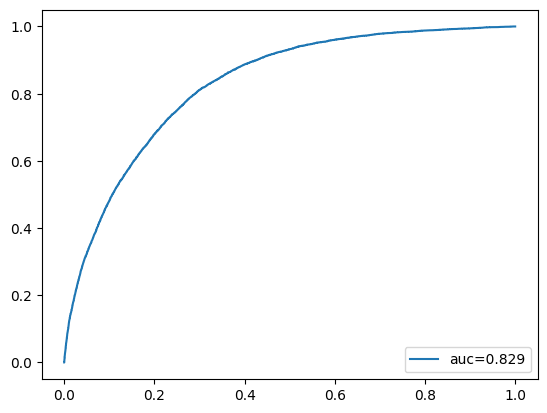

In [52]:
y_pred_proba = modelRF.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba).round(3)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()